In [51]:
# CELL 1  –– Mongo connection you already have
from collections import defaultdict
from datetime import datetime
from pymongo import MongoClient

mongoClient = MongoClient("mongodb://localhost:27017/")
db_orderbook = mongoClient["the-graph-polymarket-orderbook"]
matched_orders = db_orderbook["matched-orders"]
market_data = db_orderbook["market-data"]
db_results_rewards = db_orderbook["rewards"]

In [57]:
import pandas as pd
import numpy as np
from collections import defaultdict
from decimal import Decimal, getcontext
from math import sqrt

# ----------------------------------------------------------------------
# configuration
getcontext().prec = 40
MICRO         = 1e6          # Polymarket uses 6-decimals for USDC
TRADING_DAYS  = 365          # used for annualisation
TRADING_WEEKS = 52           # used for weekly calculations
# ----------------------------------------------------------------------

def build_pnl_df(cursor):
    """
    Iterate through matched-order docs and return a DataFrame with
    PnL, volatility (sigma) and trade counts for every maker-token pair.

    Percentage return is:
        ( realised + unrealised PnL ) / invested_capital  × 100
    where
        invested_capital = Σ(USDC spent on BUYs)
                         + max(0, -net_qty) * last_price   # cover shorts
    """

    # running book keyed by (maker, tokenId)
    book = defaultdict(lambda: {
        "cash": 0.0,                # net cash flow (+ for sells – for buys)
        "qty": 0.0,                 # net token position
        "last_price": 0.0,
        "vol": 0.0,
        "first_trade": None,
        "last_trade": None,
        "buy_cost": 0.0,            # Σ USDC laid out on BUY fills
        "sell_proceeds": 0.0,       # Σ USDC received on SELL fills
        "trades_count": 0,
        "buy_trades_count": 0,      # Number of BUY trades
        "sell_trades_count": 0      # Number of SELL trades
    })

    # price time-series per token for σ
    price_series = defaultdict(list)          # tokenId → list[(timestamp, price)]

    # ------------------------------------------------------------------
    # 1.  scan trades, update book & accumulate price data
    # ------------------------------------------------------------------
    for doc in cursor:
        maker_orders      = doc.get("makerOrders", [])
        maker_fill_amount = doc.get("makerFillAmounts", [])
        ts                = int(doc.get("timestamp", 0))

        for idx, mo in enumerate(maker_orders):
            if idx >= len(maker_fill_amount):
                continue                       # malformed record safeguard

            fill_raw = maker_fill_amount[idx]

            side      = mo["side"].upper()
            maker     = mo["maker"].lower()
            token     = mo["tokenId"]

            maker_amt = mo["makerAmount"]
            taker_amt = mo["takerAmount"]

            # ----------- translate fill into cash & qty deltas ----------
            if side == "BUY":
                usdc_spent  = fill_raw / MICRO
                price_usdc  = maker_amt / taker_amt       # USDC per token
                tokens_recv = usdc_spent / price_usdc
                cash_delta  = -usdc_spent                 # cash outflow
                qty_delta   =  tokens_recv
            else:  # SELL
                tokens_sold = fill_raw / MICRO
                price_usdc  = taker_amt / maker_amt
                usdc_recv   = tokens_sold * price_usdc
                cash_delta  =  usdc_recv                  # cash inflow
                qty_delta   = -tokens_sold

            # --------------------- update ledger ------------------------
            rec = book[(maker, token)]
            rec["cash"]        += cash_delta
            rec["qty"]         += qty_delta
            rec["last_price"]   = price_usdc
            rec["vol"]         += abs(qty_delta)
            rec["trades_count"] += 1

            if side == "BUY":
                rec["buy_cost"]         += usdc_spent
                rec["buy_trades_count"] += 1
            else:  # SELL
                rec["sell_proceeds"]     += usdc_recv
                rec["sell_trades_count"] += 1

            if rec["first_trade"] is None or ts < rec["first_trade"]:
                rec["first_trade"] = ts
            if rec["last_trade"]  is None or ts > rec["last_trade"]:
                rec["last_trade"]  = ts

            price_series[token].append((ts, price_usdc))

    # ------------------------------------------------------------------
    # 2.  realised volatility σ per tokenId (annualized)
    # ------------------------------------------------------------------
    token_sigma = {}
    for token, pairs in price_series.items():
        pairs.sort(key=lambda x: x[0])                 # chronological
        prices = np.array([p for _, p in pairs])
        if len(prices) > 1:
            log_ret = np.diff(np.log(prices))
            sigma   = np.std(log_ret, ddof=1) * sqrt(TRADING_DAYS)  # Annualized volatility
            token_sigma[token] = sigma
        else:
            token_sigma[token] = np.nan                # not enough data

    # ------------------------------------------------------------------
    # 3.  assemble DataFrame rows
    # ------------------------------------------------------------------
    rows = []
    for (maker, token), r in book.items():
        cash, qty, last_px = r["cash"], r["qty"], r["last_price"]

        # mark-to-market PnL
        pnl = cash + qty * last_px   # realised + unrealised

        # invested capital = cost of BUYs + cover any short at current price
        invested_capital = r["buy_cost"] + (max(0, -qty) * last_px)

        # avoid division by zero
        pnl_percentage = np.nan if invested_capital == 0 else (pnl / invested_capital) * 100

        # time held  (≥1 day to avoid divide-by-0 when annualising later if you wish)
        days = max(1, (r["last_trade"] - r["first_trade"]) / 86400) \
               if r["first_trade"] and r["last_trade"] else 1

        sigma  = token_sigma.get(token, np.nan)

        rows.append({
            "maker"             : maker,
            "tokenId"           : token,
            "cash_flow"         : cash,
            "net_qty"           : qty,
            "last_price"        : last_px,
            "volume"            : r["vol"],
            "pnl"               : pnl,
            "buy_cost"          : r["buy_cost"],
            "sell_proceeds"     : r["sell_proceeds"],
            "invested_capital"  : invested_capital,
            "time_period_days"  : days,
            "first_trade"       : r["first_trade"],
            "last_trade"        : r["last_trade"],
            "pnl_percentage"    : pnl_percentage,
            "sigma"             : sigma,
            "trades_count"      : r["trades_count"],
            "buy_trades_count"  : r["buy_trades_count"],
            "sell_trades_count" : r["sell_trades_count"]
        })

    return pd.DataFrame(rows)

# ----------------------------------------------------------------------
# helpers for display
# ----------------------------------------------------------------------
def _fmt_big(x):
    if pd.isna(x):
        return "n/a"
    if abs(x) >= 1e6:
        return f"{x/1e6:.2f}M"
    if abs(x) >= 1e3:
        return f"{x/1e3:.2f}K"
    return f"{x:.2f}"

def _pct(x, digits=1):
    return "n/a" if pd.isna(x) else f"{x:.{digits}f}%"


df_pnl = build_pnl_df(matched_orders.find({"complete": True}))

df_out = df_pnl.copy()
for col in ['net_qty', 'volume', 'cash_flow', 'pnl']:
    df_out[col + '_fmt'] = df_out[col].apply(_fmt_big)
df_out['return_fmt']  = df_out['pnl_percentage'].apply(_pct)
df_out['sigma_fmt']   = df_out['sigma'].apply(_pct)

# Updated output columns to include trade counts and remove sharpe
df_out = df_out[['maker','tokenId','net_qty_fmt','volume_fmt','cash_flow_fmt',
                 'pnl_fmt','return_fmt','sigma_fmt','buy_trades_count','sell_trades_count']]
print(df_out.head(20))

/Users/parshantsingh/projects/polymarket/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/parshantsingh/projects/polymarket/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


                                         maker  \
0   0x43372356634781eea88d61bbdd7824cdce958882   
1   0xa7cc7767ffb963fc5be3d455eeea68618e454952   
2   0xbc3e38a55975209dbb717a46c514f79fd736ee8f   
3   0x65f2bc996a583ca139c2bd33c73b0857f610b488   
4   0xe033c4686fd19561927bedc85beb4814a061472d   
5   0x4c0340f93e3c590118fc6e35215d51ce7dc80cc1   
6   0x43372356634781eea88d61bbdd7824cdce958882   
7   0x6b7ec4ba079c0a258435ea36025f6190cd424562   
8   0x971639c4a072d15ad14be0a8fc7584e70bad378a   
9   0xbd1d1fd1145c21e82ae29a5178693218908eb57f   
10  0xa40d51396185d72e7505402357b929c4f6f3ea7a   
11  0x505da8075db50c4fe971aacf4b56cea1289c87b2   
12  0x72603fcbdfb5a05535ab123359340f7388bfab26   
13  0x6b552487d069016a278b1837b0ba4f9f316902f8   
14  0x7789806c754eb0af4c3abeb026c218b4ba78f823   
15  0x7789806c754eb0af4c3abeb026c218b4ba78f823   
16  0xfeb581080aee6dc26c264a647b30a9cd44d5a393   
17  0x45cc78578b082e89f21e847a3afec8d28cd26400   
18  0x066a7727f53124db18aa963f900bb95b36f7550d   


After trade count filter: 15310 pairs (from 184290 original)
Makers with ≥5 qualified markets: 460
Final qualified data: 12548 pairs


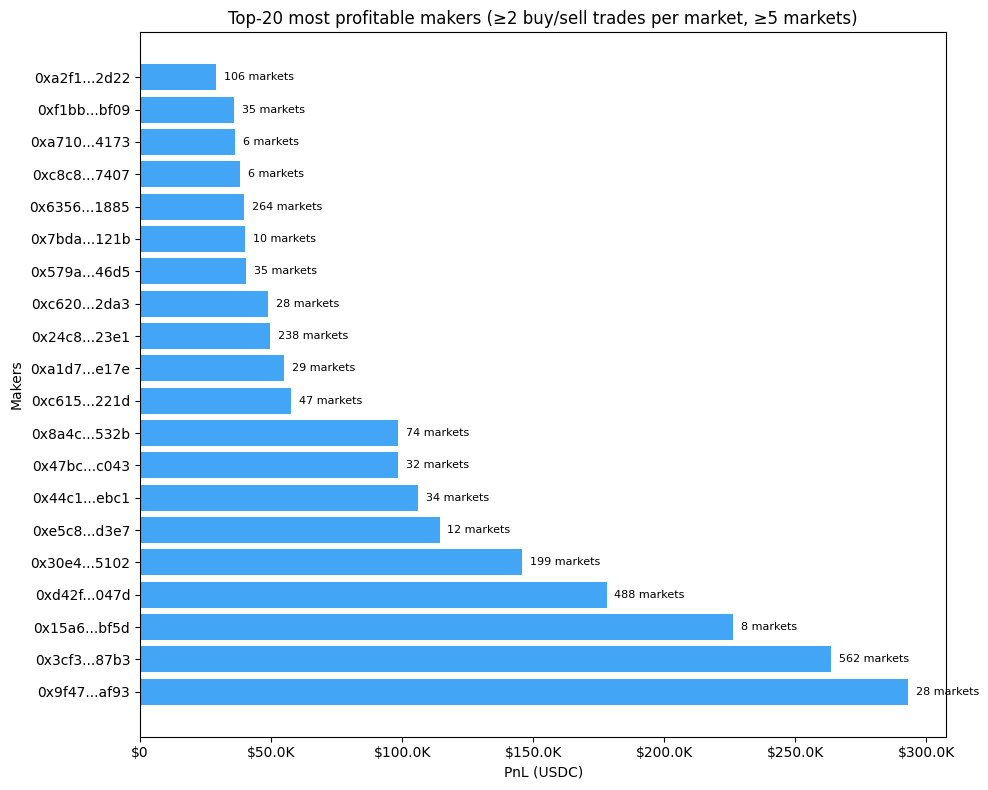


Top 20 Most Profitable Qualified Makers:
(≥2 buy and ≥2 sell trades per market, ≥5 markets total)
 1. 0x9f47f1fcb1701bf9eaf31236ad39875e5d60af93: $293.0K (28 markets, 9388 trades: 8736B/652S)
 2. 0x3cf3e8d5427aed066a7a5926980600f6c3cf87b3: $263.7K (562 markets, 40011 trades: 26183B/13828S)
 3. 0x15a681d447124c90dbd85be526af18ca1611bf5d: $226.4K (8 markets, 617 trades: 429B/188S)
 4. 0xd42f6a1634a3707e27cbae14ca966068e5d1047d: $178.1K (488 markets, 34158 trades: 23271B/10887S)
 5. 0x30e443872ddf63b2908a49f92cd690c304a55102: $145.8K (199 markets, 7594 trades: 3852B/3742S)
 6. 0xe5c8026239919339b988fdb150a7ef4ea196d3e7: $114.3K (12 markets, 2629 trades: 1741B/888S)
 7. 0x44c1dfe43260c94ed4f1d00de2e1f80fb113ebc1: $106.1K (34 markets, 1311 trades: 703B/608S)
 8. 0x47bc4b50a8d0c4a07b22bfd949f9c6afb8aec043: $98.5K (32 markets, 1167 trades: 774B/393S)
 9. 0x8a4c788f043023b8b28a762216d037e9f148532b: $98.4K (74 markets, 3664 trades: 2023B/1641S)
10. 0xc6154a43bc53f7c267d295b29510a030c489221d: $

In [72]:
# Filter for qualified makers and tokens
# Step 1: Filter df_pnl for pairs with at least 2 buy and 2 sell trades
qualified_df_pnl = df_pnl[
    (df_pnl['buy_trades_count'] >= 2) & 
    (df_pnl['sell_trades_count'] >= 5)
].copy()

print(f"After trade count filter: {len(qualified_df_pnl)} pairs (from {len(df_pnl)} original)")

# Step 2: Filter for makers with at least 5 qualified markets
maker_market_counts_qualified = qualified_df_pnl.groupby('maker')['tokenId'].nunique()
qualified_makers = maker_market_counts_qualified[maker_market_counts_qualified >= 5].index

print(f"Makers with ≥5 qualified markets: {len(qualified_makers)}")

# Step 3: Keep only rows for qualified makers
final_qualified_df_pnl = qualified_df_pnl[qualified_df_pnl['maker'].isin(qualified_makers)].copy()

print(f"Final qualified data: {len(final_qualified_df_pnl)} pairs")

# Create maker-level aggregation from qualified data
df_maker_qualified = (final_qualified_df_pnl
                     .groupby("maker")
                     .agg({
                         "pnl": "sum",
                         "buy_cost": "sum", 
                         "sell_proceeds": "sum",
                         "volume": "sum",
                         "trades_count": "sum",
                         "buy_trades_count": "sum",
                         "sell_trades_count": "sum",
                         "tokenId": "nunique"  # number of markets
                     })
                     .rename(columns={"tokenId": "num_markets"})
                     .reset_index())

# CELL 5 –– Top-20 most profitable qualified makers (horizontal bars)
top20_qualified = (df_maker_qualified
                  .set_index("maker")["pnl"]
                  .sort_values(ascending=False)
                  .head(20))

def format_address(address):
    """Format address as first4...last4"""
    if len(address) >= 8:
        return f"{address[:6]}...{address[-4:]}"
    else:
        return address

def format_amount(x):
    """Format amounts with K/M suffixes"""
    if abs(x) >= 1e6:
        return f"${x/1e6:.1f}M"
    elif abs(x) >= 1e3:
        return f"${x/1e3:.1f}K"
    else:
        return f"${x:.0f}"

# Get market counts for each qualified maker
maker_market_counts_final = final_qualified_df_pnl.groupby('maker')['tokenId'].nunique()

# Create formatted labels for y-axis
formatted_addresses = [format_address(addr) for addr in top20_qualified.index]

plt.figure(figsize=(10,8))
bars = plt.barh(range(len(top20_qualified)), top20_qualified.values, color="#42a5f5")
plt.xlabel("PnL (USDC)")
plt.ylabel("Makers")
plt.title("Top-20 most profitable makers (≥2 buy/sell trades per market, ≥5 markets)")
plt.yticks(range(len(top20_qualified)), formatted_addresses)

# Add market count at the end of each bar
for i, (bar, maker) in enumerate(zip(bars, top20_qualified.index)):
    market_count = maker_market_counts_final.get(maker, 0)
    plt.text(bar.get_width() + max(top20_qualified.values)*0.01, 
             bar.get_y() + bar.get_height()/2, 
             f"{market_count} markets", va='center', ha='left', fontsize=8)

# Format x-axis ticks with K/M notation
import matplotlib.ticker as ticker
def format_x_axis(x, p):
    return format_amount(x)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_x_axis))

plt.tight_layout()
plt.savefig('top20_makers_qualified.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Print the full addresses and PnL values with market counts and trade stats
print("\nTop 20 Most Profitable Qualified Makers:")
print("=" * 80)
print("(≥2 buy and ≥2 sell trades per market, ≥5 markets total)")
print("=" * 80)
for i, (address, pnl_value) in enumerate(top20_qualified.items(), 1):
    market_count = maker_market_counts_final.get(address, 0)
    maker_stats = df_maker_qualified[df_maker_qualified['maker'] == address].iloc[0]
    total_trades = maker_stats['trades_count']
    buy_trades = maker_stats['buy_trades_count']
    sell_trades = maker_stats['sell_trades_count']
    
    print(f"{i:2d}. {address}: {format_amount(pnl_value)} "
          f"({market_count} markets, {total_trades} trades: {buy_trades}B/{sell_trades}S)")

print(f"\nSummary:")
print(f"Total qualified makers: {len(qualified_makers)}")
print(f"Average markets per qualified maker: {final_qualified_df_pnl.groupby('maker').size().mean():.1f}")
print(f"Total qualified (maker,token) pairs: {len(final_qualified_df_pnl)}")

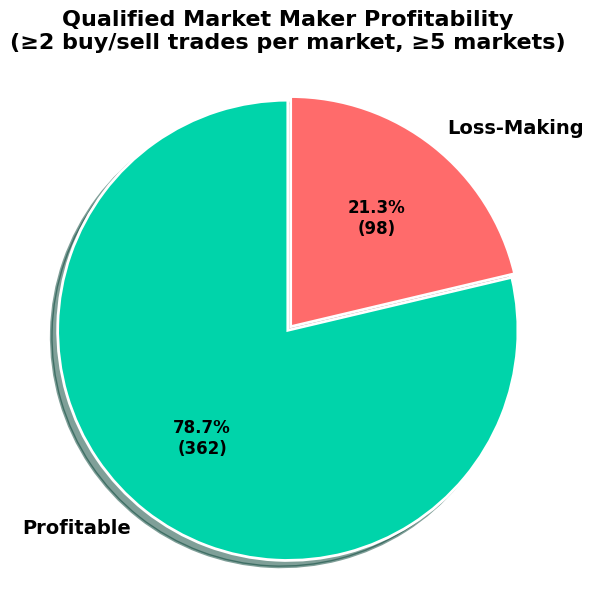

📊 QUALIFIED MAKER PROFITABILITY BREAKDOWN
(≥2 buy/sell trades per market, ≥5 markets)
🟢 Profitable qualified makers: 362 (78.7%)
🔴 Unprofitable qualified makers: 98 (21.3%)
📈 Total qualified makers: 460

📊 COMPARISON:
Original total makers: 26,017
Qualified makers: 460
Qualification rate: 1.8%


In [73]:
# CELL 4 –– pie chart: profitable vs unprofitable QUALIFIED MAKERS
import matplotlib.pyplot as plt

# Calculate profitability for qualified makers only
profitable_makers_qualified = (df_maker_qualified['pnl'] > 0).sum()
unprofitable_makers_qualified = (df_maker_qualified['pnl'] < 0).sum()
neutral_makers_qualified = (df_maker_qualified['pnl'] == 0).sum()

sizes = [profitable_makers_qualified, unprofitable_makers_qualified]
labels = ["Profitable", "Loss-Making"]

# Create figure with modern styling
plt.figure(figsize=(6, 6))

# Define colors with gradients feel
colors = ["#00d4aa", "#ff6b6b"]  # Teal green and coral red

# Create the pie chart with modern styling
wedges, texts, autotexts = plt.pie(
    sizes, 
    labels=labels, 
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(sizes)):,})',
    colors=colors,
    startangle=90,
    explode=(0.01, 0.01),  # Slight separation
    shadow=True,
    textprops={'fontsize': 14, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Customize the percentage text
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

# Add a title with better formatting
plt.title('Qualified Market Maker Profitability\n(≥2 buy/sell trades per market, ≥5 markets)', 
          fontsize=16, fontweight='bold', pad=20, color='black')

# Equal aspect ratio and remove axes
plt.axis('equal')
plt.tight_layout()

plt.savefig('qualified_makers_profitability.pdf', format='pdf', bbox_inches='tight', 
            dpi=300)
plt.show()

# Print the actual numbers with better formatting
total_makers_qualified = profitable_makers_qualified + unprofitable_makers_qualified
print("📊 QUALIFIED MAKER PROFITABILITY BREAKDOWN")
print("=" * 50)
print("(≥2 buy/sell trades per market, ≥5 markets)")
print("=" * 50)
print(f"🟢 Profitable qualified makers: {profitable_makers_qualified:,} ({profitable_makers_qualified/total_makers_qualified*100:.1f}%)")
print(f"🔴 Unprofitable qualified makers: {unprofitable_makers_qualified:,} ({unprofitable_makers_qualified/total_makers_qualified*100:.1f}%)")
if neutral_makers_qualified > 0:
    print(f"⚪ Neutral qualified makers: {neutral_makers_qualified:,}")
print(f"📈 Total qualified makers: {total_makers_qualified:,}")

# Compare with overall stats if available
if 'df_maker' in locals():
    total_original_makers = len(df_maker)
    print(f"\n📊 COMPARISON:")
    print(f"Original total makers: {total_original_makers:,}")
    print(f"Qualified makers: {total_makers_qualified:,}")
    print(f"Qualification rate: {total_makers_qualified/total_original_makers*100:.1f}%")

In [74]:
# Single query for both politics and sports tags
query = {
    "complete": True,
    "tags": {
        "$in": ["politics", "election", "elections", "us-election", "us-elections", "sports", "sport", "crypto", "cryptocurrency", "cryptocurrencies"]
    }
}

# Initialize categories dictionary
token_categories = {}

# Get all documents with either politics or sports tags
docs = matched_orders.find(query, {"clobTokenIds": 1, "tags": 1})

for doc in docs:
    clob_token_ids = doc.get("clobTokenIds", [])
    tags = doc.get("tags", [])
    
    # Determine category based on tags
    if any(tag in ["politics", "election", "elections", "us-election", "us-elections"] for tag in tags):
        category = "politics"
    elif any(tag in ["sports", "sport"] for tag in tags):
        category = "sports"
    elif any(tag in ["crypto", "cryptocurrency", "cryptocurrencies"] for tag in tags):
        category = "crypto"
    else:
        continue  # Skip if neither category
    
    # Map each clobTokenId to the category
    for token_id in clob_token_ids:
        token_categories[str(token_id)] = category

# Print results
politics_count = sum(1 for cat in token_categories.values() if cat == "politics")
sports_count = sum(1 for cat in token_categories.values() if cat == "sports")
crypto_count = sum(1 for cat in token_categories.values() if cat == "crypto")

print(f"Unique clobTokenIds with politics tags: {politics_count:,}")
print(f"Unique clobTokenIds with sports tags: {sports_count:,}")
print(f"Unique clobTokenIds with crypto tags: {crypto_count:,}")
print(f"Total unique clobTokenIds: {len(token_categories):,}")


Unique clobTokenIds with politics tags: 2,780
Unique clobTokenIds with sports tags: 2,838
Unique clobTokenIds with crypto tags: 668
Total unique clobTokenIds: 6,286


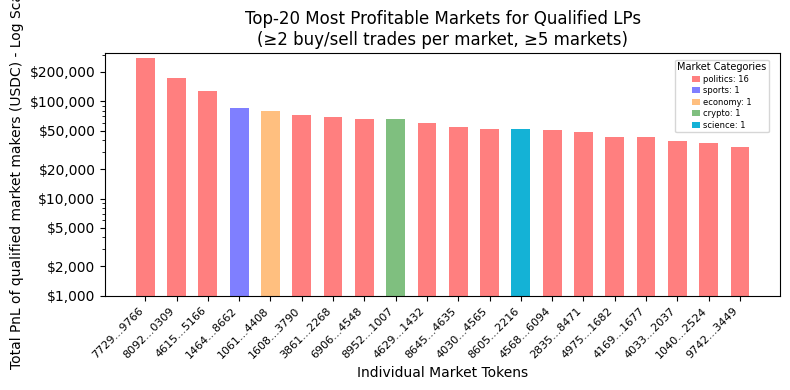


Top 20 Most Profitable Token IDs (Qualified Makers Only):
(≥2 buy/sell trades per market, ≥5 markets)
 1. 77290004420469807303121418983410594259783349435877463527461916026337527709766 (politics): $281,184.73 (104 qualified makers)
 2. 80925468211616514689801729831224127559514739808468898917139925998254451700309 (politics): $172,027.01 (39 qualified makers)
 3. 46151683995628303683848849165180379776066478517400313383689588032121505705166 (politics): $128,359.75 (26 qualified makers)
 4. 14640179115109297633267329685904845732820014682948090838736461671975794258662 (sports): $85,702.44 (12 qualified makers)
 5. 106191328358576540351439267765925450329859429577455659884974413809922495874408 (economy): $79,531.35 (76 qualified makers)
 6. 16089502285715435437562615795573134003254593059489358511668863095586726453790 (politics): $72,706.27 (42 qualified makers)
 7. 3861515218334116049080746561355718445376798695924639523869032918007220502268 (politics): $69,348.95 (16 qualified makers)
 8. 690

In [76]:
token_categories["106191328358576540351439267765925450329859429577455659884974413809922495874408"] = 'economy'
token_categories["86053089509266604208617788313596238010701073083271989157480011657158511212216"] = 'science'
token_categories["45684115051063786369424575671570278148366024330058665274769842376099284186094"] = 'politics'
token_categories["97425038822609335902911118411024732611111441344029214511050402633715224673449"] = 'politics'

# Use qualified data instead of all df_pnl data
token_pnl_qualified = (final_qualified_df_pnl
                      .groupby("tokenId")["pnl"]
                      .sum()
                      .sort_values(ascending=False)
                      .head(20))

def format_token_label(token_id):
    """Format token ID as first4...last4"""
    if len(token_id) >= 8:
        return f"{token_id[:4]}...{token_id[-4:]}"
    else:
        return token_id

# Count categories for qualified tokens
from collections import Counter
categories_qualified = [token_categories.get(str(token_id), 'unknown') for token_id in token_pnl_qualified.index]
category_counts_qualified = Counter(categories_qualified)

# Create color mapping for categories
category_colors = {
    'politics': '#ff7f7f',
    'crypto': '#7fbf7f', 
    'sports': '#7f7fff',
    'economy': '#ffbf7f',
    'science': "#14b2d6"
}

# Create formatted labels and colors for the plot
formatted_labels_qualified = [format_token_label(str(token_id)) for token_id in token_pnl_qualified.index]
bar_colors_qualified = [category_colors.get(token_categories.get(str(token_id), 'unknown'), '#bfbfbf') 
                       for token_id in token_pnl_qualified.index]

plt.figure(figsize=(8,4))
bars = plt.bar(range(len(token_pnl_qualified)), token_pnl_qualified.values, 
               color=bar_colors_qualified, width=0.6)

plt.xlabel("Individual Market Tokens")
plt.ylabel("Total PnL of qualified market makers (USDC) - Log Scale")
plt.title("Top-20 Most Profitable Markets for Qualified LPs\n(≥2 buy/sell trades per market, ≥5 markets)")
plt.yscale('log')

# Set more detailed y-axis ticks
import numpy as np
y_ticks = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
plt.yticks(y_ticks, [f"${tick:,}" for tick in y_ticks])

plt.xticks(range(len(token_pnl_qualified)), formatted_labels_qualified, 
           rotation=45, ha="right", fontsize=8)

# Create proper colored legend for qualified data
from matplotlib.patches import Patch
legend_elements_qualified = []
for cat, count in category_counts_qualified.items():
    color = category_colors.get(cat, '#bfbfbf')  # Default to gray if category not found
    legend_elements_qualified.append(Patch(facecolor=color, label=f'{cat}: {count}'))

plt.legend(
    handles=legend_elements_qualified,
    title="Market Categories",
    loc='upper right',
    bbox_to_anchor=(0.99, 0.99),
    fontsize=6,                # smaller text
    title_fontsize=7,           # smaller title
    borderpad=0.3,              # shrink padding inside legend
    labelspacing=0.3,           # reduce space between entries
    handlelength=1,             # shorter handles
    handletextpad=0.4           # reduce space between handle and text
)

plt.tight_layout()
plt.savefig('top20_tokens_qualified.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Print the token IDs and their PnL values with categories
print("\nTop 20 Most Profitable Token IDs (Qualified Makers Only):")
print("=" * 80)
print("(≥2 buy/sell trades per market, ≥5 markets)")
print("=" * 80)
for i, (token_id, pnl_value) in enumerate(token_pnl_qualified.items(), 1):
    category = token_categories.get(str(token_id), 'unknown')
    # Count how many qualified makers traded this token
    makers_count = final_qualified_df_pnl[final_qualified_df_pnl['tokenId'] == token_id]['maker'].nunique()
    print(f"{i:2d}. {token_id} ({category}): ${pnl_value:,.2f} ({makers_count} qualified makers)")

# Compare with overall token performance if available
if 'df_pnl' in locals():
    print(f"\n📊 COMPARISON:")
    total_tokens_all = df_pnl['tokenId'].nunique()
    total_tokens_qualified = final_qualified_df_pnl['tokenId'].nunique()
    print(f"Total tokens (all makers): {total_tokens_all:,}")
    print(f"Total tokens (qualified makers): {total_tokens_qualified:,}")
    print(f"Coverage rate: {total_tokens_qualified/total_tokens_all*100:.1f}%")

Starting the mapping of token categories...
Total unique tokens in plot_df: 5,732


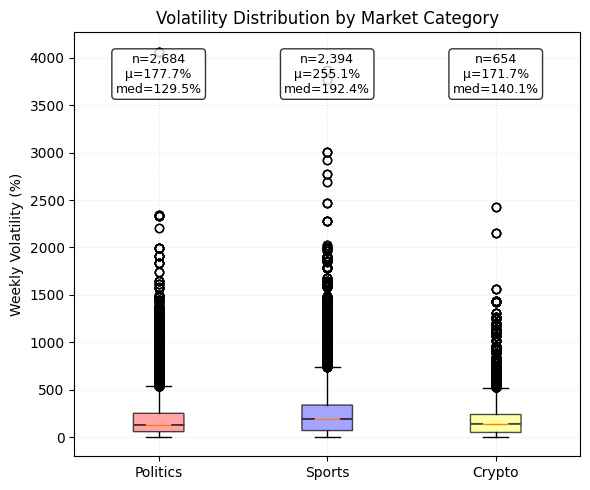

In [24]:
import matplotlib.pyplot as plt

# Prepare the data
plot_df = df_pnl.dropna(subset=['sigma'])
plot_df = plot_df[plot_df['sigma'] > 0]
print(f"Starting the mapping of token categories...")
plot_df['category'] = plot_df['tokenId'].map(lambda t: token_categories.get(str(t), 'unknown'))
plot_df = plot_df[plot_df['category'].isin(['politics', 'sports', 'crypto'])]

print(f"Total unique tokens in plot_df: {plot_df['tokenId'].nunique():,}")

# Pre-filter data for each category to avoid repeated filtering
politics_data = plot_df[plot_df['category'] == 'politics']['sigma'] * 100
sports_data = plot_df[plot_df['category'] == 'sports']['sigma'] * 100
crypto_data = plot_df[plot_df['category'] == 'crypto']['sigma'] * 100

# Create box plot
plt.figure(figsize=(6, 5))
box_plot = plt.boxplot(
    [politics_data, sports_data, crypto_data],
    tick_labels=['Politics', 'Sports', 'Crypto'],  # Fixed deprecation warning
    patch_artist=True,
    notch=True
)

# Color the boxes
colors = ['#ff7f7f', '#7f7fff', '#ffff7f']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Weekly Volatility (%)')
plt.title('Volatility Distribution by Market Category')
plt.grid(True, linestyle=':', alpha=0.3)

# Add sample counts and statistics
categories = ['politics', 'sports', 'crypto']
category_data = [politics_data, sports_data, crypto_data]

for i, (cat, data) in enumerate(zip(categories, category_data)):
    count = plot_df[plot_df['category'] == cat]['tokenId'].nunique()
    mean_val = data.mean()
    median_val = data.median()
    
    plt.text(i+1, plt.gca().get_ylim()[1] * 0.95, 
             f'n={count:,}\nμ={mean_val:.1f}%\nmed={median_val:.1f}%',
             ha='center', va='top', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('volatility_by_category.pdf', format='pdf', dpi=300)
plt.show()

Sample qualified maker: 0x8f23aead02f055b69c7f7db51a2d74187bb2c7d0
Qualified Maker 0x8f23...c7d0 was involved in 18 qualified markets


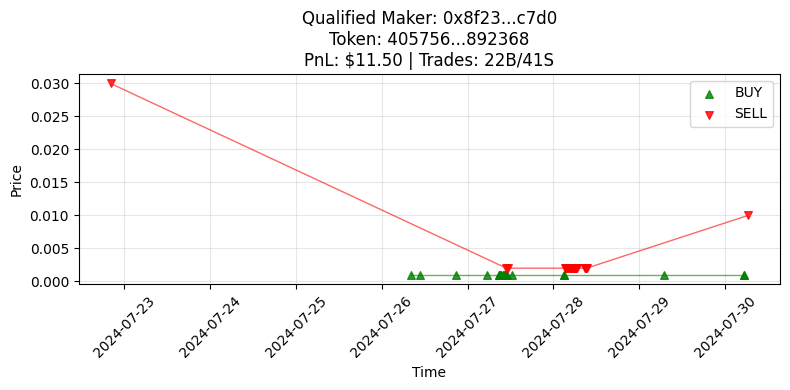

Qualified Market 1 - Token: 40575689206241828104168403500764269766001900312039562643760836580776975892368
PnL: $11.50
Qualified Trades: 22 BUY + 41 SELL = 63 total
All Executed Trades: 63 (BUY: 22, SELL: 41)
BUY Volume: 2565.31 tokens ($2.57 USDC)
SELL Volume: 3699.44 tokens ($16.33 USDC)
Net Token Position: -1134.13 tokens
Net USDC Flow: $13.77
--------------------------------------------------


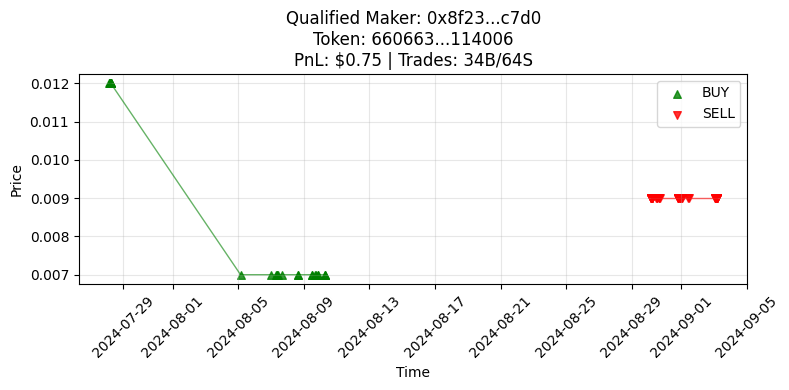

Qualified Market 2 - Token: 66066379485288400932839585638304895155726200324243998640721576168136495114006
PnL: $0.75
Qualified Trades: 34 BUY + 64 SELL = 98 total
All Executed Trades: 98 (BUY: 34, SELL: 64)
BUY Volume: 2249.99 tokens ($19.50 USDC)
SELL Volume: 2999.99 tokens ($27.00 USDC)
Net Token Position: -750.00 tokens
Net USDC Flow: $7.50
--------------------------------------------------


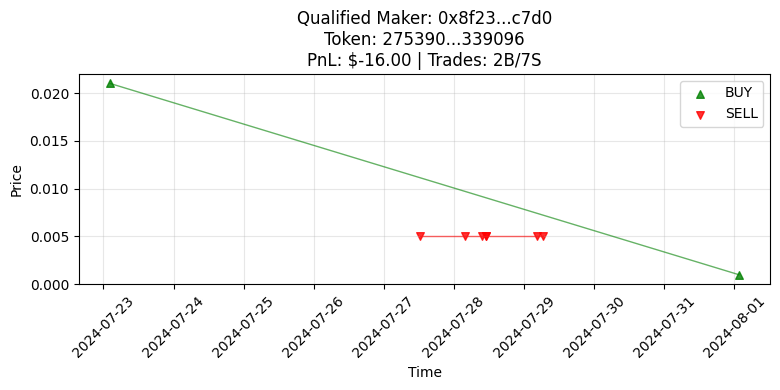

Qualified Market 3 - Token: 2753907700619192122306498023508292164194512738763751725871101812106941339096
PnL: $-16.00
Qualified Trades: 2 BUY + 7 SELL = 9 total
All Executed Trades: 9 (BUY: 2, SELL: 7)
BUY Volume: 3500.00 tokens ($33.50 USDC)
SELL Volume: 2126.00 tokens ($10.63 USDC)
Net Token Position: 1374.00 tokens
Net USDC Flow: $-22.87
--------------------------------------------------


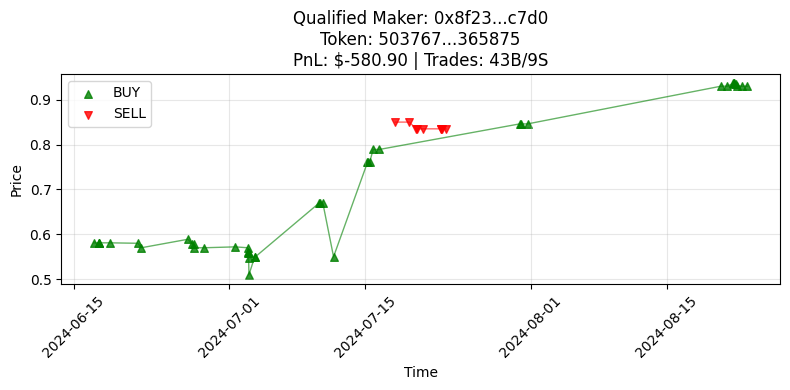

Qualified Market 4 - Token: 50376722767982976792819483321675476184683505970028931051190616149906273365875
PnL: $-580.90
Qualified Trades: 43 BUY + 9 SELL = 52 total
All Executed Trades: 52 (BUY: 43, SELL: 9)
BUY Volume: 14597.82 tokens ($10165.27 USDC)
SELL Volume: 4200.85 tokens ($3543.73 USDC)
Net Token Position: 10396.96 tokens
Net USDC Flow: $-6621.54
--------------------------------------------------


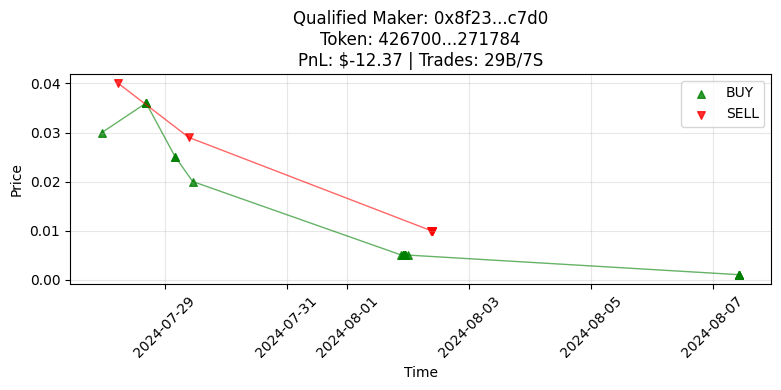

Qualified Market 5 - Token: 42670021288640748719230174014589198808293002543549115393548142478567753271784
PnL: $-12.37
Qualified Trades: 29 BUY + 7 SELL = 36 total
All Executed Trades: 36 (BUY: 29, SELL: 7)
BUY Volume: 9705.98 tokens ($106.65 USDC)
SELL Volume: 4006.50 tokens ($65.79 USDC)
Net Token Position: 5699.48 tokens
Net USDC Flow: $-40.86
--------------------------------------------------


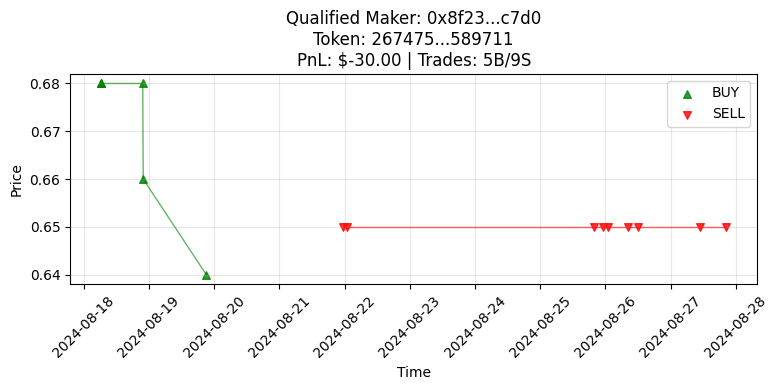

Qualified Market 6 - Token: 26747589474790680595528828356565476732894545622710420461232524568949829589711
PnL: $-30.00
Qualified Trades: 5 BUY + 9 SELL = 14 total
All Executed Trades: 14 (BUY: 5, SELL: 9)
BUY Volume: 2000.00 tokens ($1330.00 USDC)
SELL Volume: 2259.99 tokens ($1468.99 USDC)
Net Token Position: -259.99 tokens
Net USDC Flow: $138.99
--------------------------------------------------


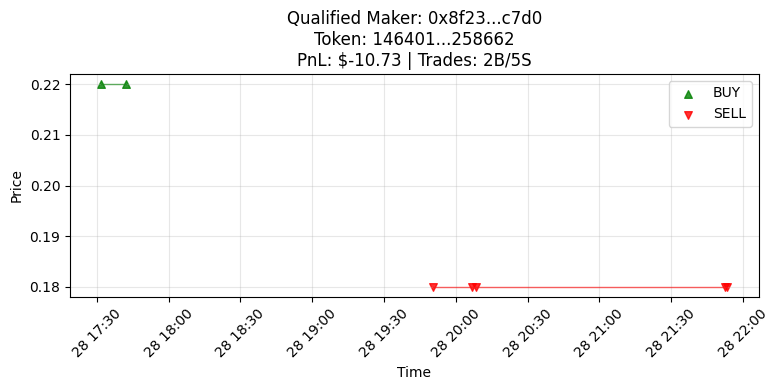

Qualified Market 7 - Token: 14640179115109297633267329685904845732820014682948090838736461671975794258662
PnL: $-10.73
Qualified Trades: 2 BUY + 5 SELL = 7 total
All Executed Trades: 7 (BUY: 2, SELL: 5)
BUY Volume: 199.99 tokens ($44.00 USDC)
SELL Volume: 268.13 tokens ($48.26 USDC)
Net Token Position: -68.14 tokens
Net USDC Flow: $4.27
--------------------------------------------------


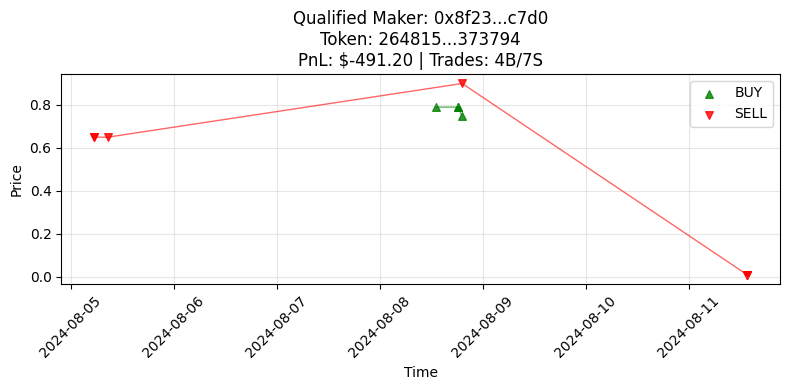

Qualified Market 8 - Token: 26481522260669325525885054154884170011812830571402122483807309293175635373794
PnL: $-491.20
Qualified Trades: 4 BUY + 7 SELL = 11 total
All Executed Trades: 11 (BUY: 4, SELL: 7)
BUY Volume: 900.01 tokens ($691.01 USDC)
SELL Volume: 720.01 tokens ($198.01 USDC)
Net Token Position: 180.00 tokens
Net USDC Flow: $-493.00
--------------------------------------------------


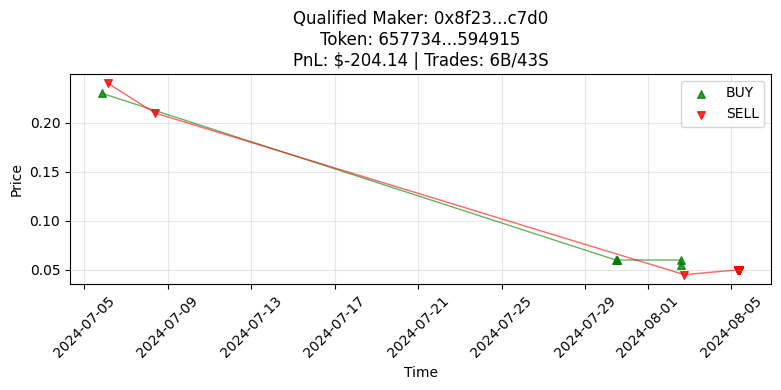

Qualified Market 9 - Token: 65773435103546041498070625786375232393837706669787188912401598120638608594915
PnL: $-204.14
Qualified Trades: 6 BUY + 43 SELL = 49 total
All Executed Trades: 49 (BUY: 6, SELL: 43)
BUY Volume: 3999.99 tokens ($405.00 USDC)
SELL Volume: 3005.40 tokens ($141.18 USDC)
Net Token Position: 994.59 tokens
Net USDC Flow: $-263.82
--------------------------------------------------


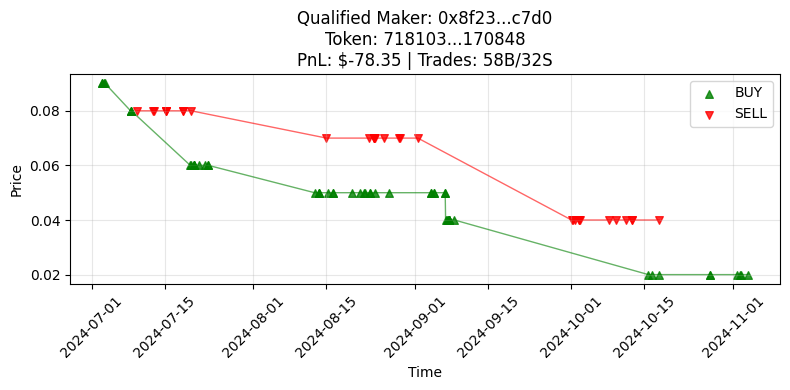

Qualified Market 10 - Token: 71810370107620632006650744852200102594026683444305751948992424532824734170848
PnL: $-78.35
Qualified Trades: 58 BUY + 32 SELL = 90 total
All Executed Trades: 90 (BUY: 58, SELL: 32)
BUY Volume: 6661.53 tokens ($364.07 USDC)
SELL Volume: 3755.45 tokens ($169.47 USDC)
Net Token Position: 2906.08 tokens
Net USDC Flow: $-194.60
--------------------------------------------------


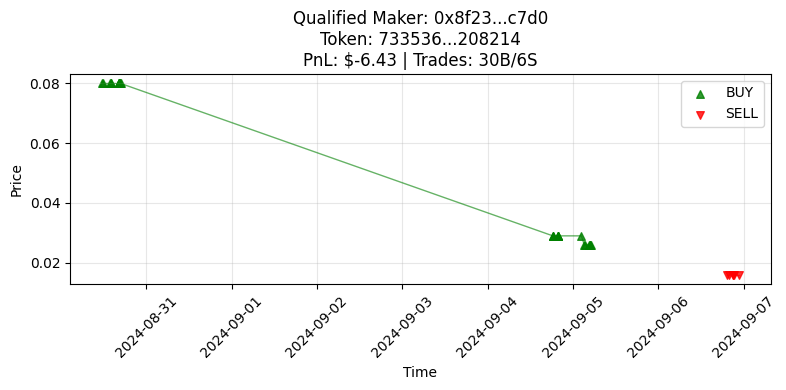

Qualified Market 11 - Token: 73353623077690387697518365074962973672352441091077404142653350970782532208214
PnL: $-6.43
Qualified Trades: 30 BUY + 6 SELL = 36 total
All Executed Trades: 36 (BUY: 30, SELL: 6)
BUY Volume: 3445.55 tokens ($130.38 USDC)
SELL Volume: 2370.14 tokens ($37.92 USDC)
Net Token Position: 1075.41 tokens
Net USDC Flow: $-92.46
--------------------------------------------------


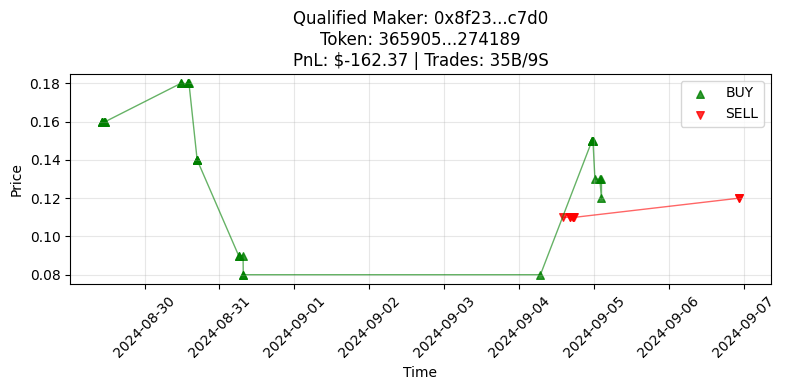

Qualified Market 12 - Token: 36590575886872728042445424647846711900134084669677989013916889641522570274189
PnL: $-162.37
Qualified Trades: 35 BUY + 9 SELL = 44 total
All Executed Trades: 44 (BUY: 35, SELL: 9)
BUY Volume: 6727.99 tokens ($796.89 USDC)
SELL Volume: 1349.98 tokens ($150.50 USDC)
Net Token Position: 5378.01 tokens
Net USDC Flow: $-646.39
--------------------------------------------------


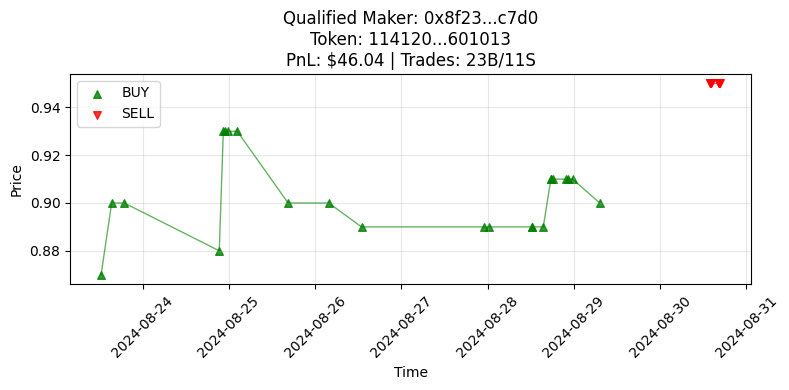

Qualified Market 13 - Token: 11412015639700663530230283466851902430721994691354634292515910680000198601013
PnL: $46.04
Qualified Trades: 23 BUY + 11 SELL = 34 total
All Executed Trades: 34 (BUY: 23, SELL: 11)
BUY Volume: 3912.03 tokens ($3534.75 USDC)
SELL Volume: 521.30 tokens ($495.24 USDC)
Net Token Position: 3390.72 tokens
Net USDC Flow: $-3039.52
--------------------------------------------------


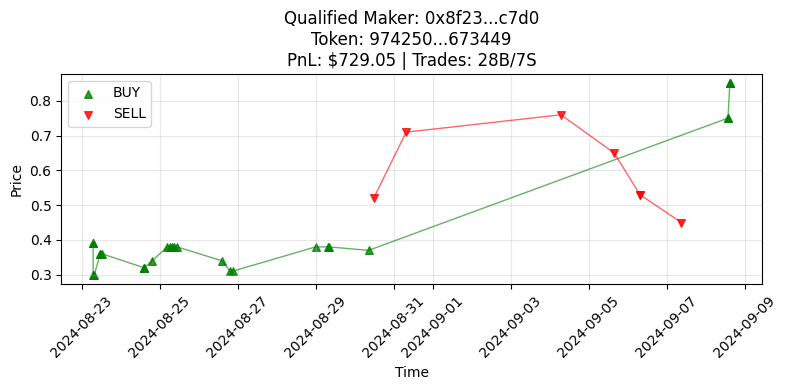

Qualified Market 14 - Token: 97425038822609335902911118411024732611111441344029214511050402633715224673449
PnL: $729.05
Qualified Trades: 28 BUY + 7 SELL = 35 total
All Executed Trades: 35 (BUY: 28, SELL: 7)
BUY Volume: 2767.77 tokens ($1200.54 USDC)
SELL Volume: 1281.56 tokens ($814.93 USDC)
Net Token Position: 1486.21 tokens
Net USDC Flow: $-385.61
--------------------------------------------------


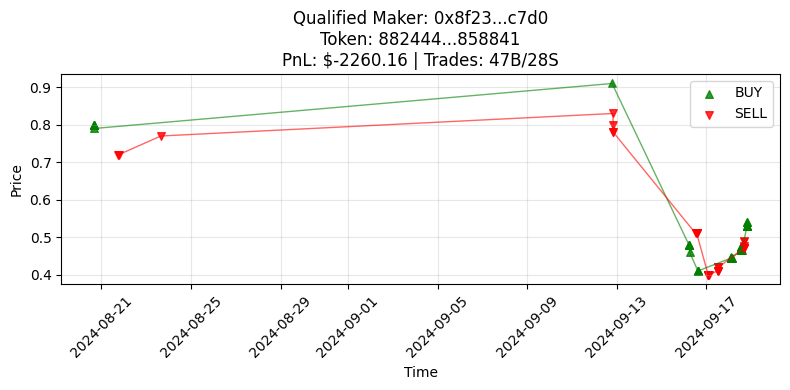

Qualified Market 15 - Token: 88244443360063235221444316604590968694314258311386447899087521723508440858841
PnL: $-2260.16
Qualified Trades: 47 BUY + 28 SELL = 75 total
All Executed Trades: 75 (BUY: 47, SELL: 28)
BUY Volume: 21581.11 tokens ($13180.16 USDC)
SELL Volume: 13363.54 tokens ($7632.97 USDC)
Net Token Position: 8217.57 tokens
Net USDC Flow: $-5547.19
--------------------------------------------------


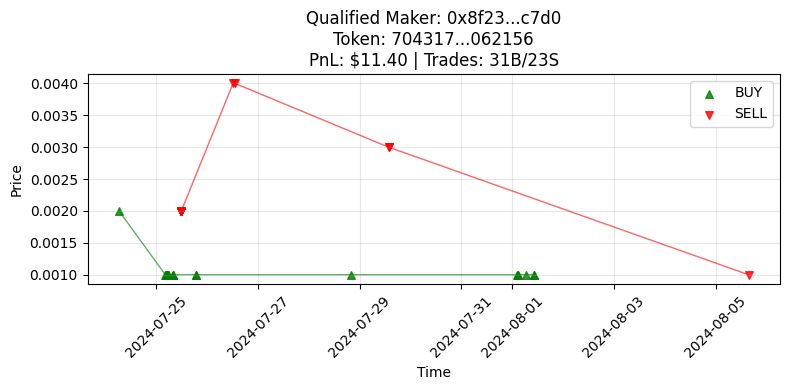

Qualified Market 16 - Token: 70431798564328500286262619243704295125787422684334652571326088734755454062156
PnL: $11.40
Qualified Trades: 31 BUY + 23 SELL = 54 total
All Executed Trades: 54 (BUY: 31, SELL: 23)
BUY Volume: 7999.91 tokens ($9.00 USDC)
SELL Volume: 10397.58 tokens ($22.80 USDC)
Net Token Position: -2397.67 tokens
Net USDC Flow: $13.80
--------------------------------------------------


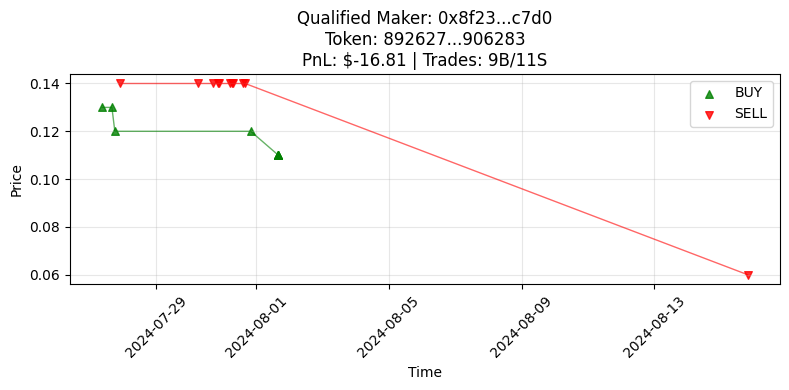

Qualified Market 17 - Token: 89262722133387845193166560202808972424089924545438804960915341631492994906283
PnL: $-16.81
Qualified Trades: 9 BUY + 11 SELL = 20 total
All Executed Trades: 20 (BUY: 9, SELL: 11)
BUY Volume: 2100.00 tokens ($253.00 USDC)
SELL Volume: 1872.55 tokens ($204.34 USDC)
Net Token Position: 227.45 tokens
Net USDC Flow: $-48.66
--------------------------------------------------


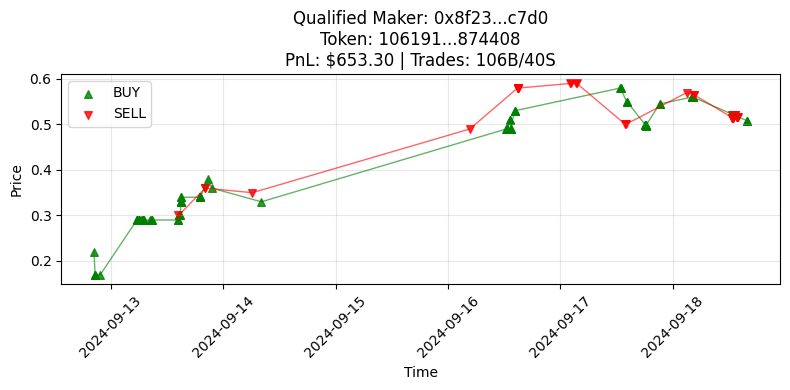

Qualified Market 18 - Token: 106191328358576540351439267765925450329859429577455659884974413809922495874408
PnL: $653.30
Qualified Trades: 106 BUY + 40 SELL = 146 total
All Executed Trades: 146 (BUY: 106, SELL: 40)
BUY Volume: 48990.93 tokens ($18026.34 USDC)
SELL Volume: 22148.65 tokens ($9553.27 USDC)
Net Token Position: 26842.28 tokens
Net USDC Flow: $-8473.07
--------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np

def plot_qualified_maker_trading_activity(maker_address, final_qualified_df_pnl, matched_orders, tokens=None):
    """
    Simple plots showing executed bids (green triangles) and asks (red triangles) with connecting lines
    Only considers qualified trading data (≥2 buy/sell trades per market, ≥5 markets)
    """
    # Check if this maker is in the qualified dataset
    if maker_address not in final_qualified_df_pnl['maker'].values:
        print(f"Maker {maker_address[:6]}...{maker_address[-4:]} is not in the qualified dataset")
        print("(Must have ≥2 buy and ≥2 sell trades per market, and ≥5 total markets)")
        return
    
    # Get all qualified markets this maker was involved in
    if tokens is None:
        maker_markets = final_qualified_df_pnl[
            final_qualified_df_pnl['maker'] == maker_address
        ]['tokenId'].unique()
    else:
        maker_markets = final_qualified_df_pnl[
            (final_qualified_df_pnl['maker'] == maker_address) & 
            (final_qualified_df_pnl["tokenId"].isin(tokens))
        ]['tokenId'].unique()
    
    print(f"Qualified Maker {maker_address[:6]}...{maker_address[-4:]} was involved in {len(maker_markets)} qualified markets")
    
    for market_idx, token_id in enumerate(maker_markets):
        # Get PnL for this market from qualified df_pnl
        market_row = final_qualified_df_pnl[
            (final_qualified_df_pnl['maker'] == maker_address) & 
            (final_qualified_df_pnl['tokenId'] == token_id)
        ]
        
        if market_row.empty:
            continue
            
        market_pnl = market_row['pnl'].iloc[0]
        buy_trades_count = market_row['buy_trades_count'].iloc[0]
        sell_trades_count = market_row['sell_trades_count'].iloc[0]
        
        # Query all executed trades for this maker and token
        query = {
            "complete": True,
            "makerOrders": {
                "$elemMatch": {
                    "maker": maker_address,
                    "tokenId": token_id
                }
            }
        }
        
        trades_data = []
        
        for doc in matched_orders.find(query):
            timestamp = int(doc.get("timestamp", 0))
            makerOrders = doc.get("makerOrders", [])
            makerFillAmounts = doc.get("makerFillAmounts", [])
            
            for idx, mo in enumerate(makerOrders):
                if mo["maker"].lower() != maker_address.lower() or mo["tokenId"] != token_id:
                    continue
                    
                if idx >= len(makerFillAmounts):
                    continue
                
                side = mo["side"].upper()
                maker_amount = int(mo["makerAmount"]) / 1e6
                taker_amount = int(mo["takerAmount"]) / 1e6
                fill_amount = int(makerFillAmounts[idx]) / 1e6
                
                if side == "BUY":
                    price = maker_amount / taker_amount
                    # For BUY: fill_amount is USDC spent, volume in tokens = fill_amount / price
                    token_volume = fill_amount / price
                    usdc_volume = fill_amount
                else:  # SELL
                    price = taker_amount / maker_amount
                    # For SELL: fill_amount is tokens sold, volume in USDC = fill_amount * price
                    token_volume = fill_amount
                    usdc_volume = fill_amount * price
                
                trades_data.append({
                    'timestamp': timestamp,
                    'datetime': datetime.fromtimestamp(timestamp),
                    'side': side,
                    'price': price,
                    'token_volume': token_volume,
                    'usdc_volume': usdc_volume
                })
        
        if not trades_data:
            print(f"No trading data found for qualified market {token_id}")
            continue
            
        # Convert to DataFrame and sort by timestamp
        df_trades = pd.DataFrame(trades_data).sort_values('timestamp')
        
        # Separate buys and sells
        buys = df_trades[df_trades['side'] == 'BUY']
        sells = df_trades[df_trades['side'] == 'SELL']
        
        # Calculate volumes
        buy_token_volume = buys['token_volume'].sum() if not buys.empty else 0
        sell_token_volume = sells['token_volume'].sum() if not sells.empty else 0
        buy_usdc_volume = buys['usdc_volume'].sum() if not buys.empty else 0
        sell_usdc_volume = sells['usdc_volume'].sum() if not sells.empty else 0
        
        # Create the plot
        plt.figure(figsize=(8, 4))
        
        # Plot executed BUY orders as small green triangles
        if not buys.empty:
            plt.scatter(buys['datetime'], buys['price'], 
                       s=30, color='green', marker='^', 
                       label='BUY', alpha=0.8)
            # Connect with green line
            plt.plot(buys['datetime'], buys['price'], 
                    color='green', alpha=0.6, linewidth=1)
        
        # Plot executed SELL orders as small red triangles
        if not sells.empty:
            plt.scatter(sells['datetime'], sells['price'], 
                       s=30, color='red', marker='v', 
                       label='SELL', alpha=0.8)
            # Connect with red line
            plt.plot(sells['datetime'], sells['price'], 
                    color='red', alpha=0.6, linewidth=1)
        
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.title(f'Qualified Maker: {maker_address[:6]}...{maker_address[-4:]}\n'
                 f'Token: {str(token_id)[:6]}...{str(token_id)[-6:]}\n'
                 f'PnL: ${market_pnl:.2f} | Trades: {buy_trades_count}B/{sell_trades_count}S')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'qualified_spread_{market_idx}.pdf', format='pdf', bbox_inches='tight', dpi=300)
        plt.show()
        
        print(f"Qualified Market {market_idx+1} - Token: {token_id}")
        print(f"PnL: ${market_pnl:.2f}")
        print(f"Qualified Trades: {buy_trades_count} BUY + {sell_trades_count} SELL = {buy_trades_count + sell_trades_count} total")
        print(f"All Executed Trades: {len(df_trades)} (BUY: {len(buys)}, SELL: {len(sells)})")
        print(f"BUY Volume: {buy_token_volume:.2f} tokens (${buy_usdc_volume:.2f} USDC)")
        print(f"SELL Volume: {sell_token_volume:.2f} tokens (${sell_usdc_volume:.2f} USDC)")
        print(f"Net Token Position: {buy_token_volume - sell_token_volume:.2f} tokens")
        print(f"Net USDC Flow: ${sell_usdc_volume - buy_usdc_volume:.2f}")
        print("-" * 50)

# Usage - try with a qualified maker
# First, let's find a qualified maker to test with
if len(final_qualified_df_pnl) > 0:
    sample_qualified_maker = final_qualified_df_pnl['maker'].iloc[0]
    print(f"Sample qualified maker: {sample_qualified_maker}")
    plot_qualified_maker_trading_activity(sample_qualified_maker, final_qualified_df_pnl, matched_orders)
else:
    print("No qualified makers found in the dataset")

# Or test with a specific maker if you know they're qualified
maker_address = "0xc8c80d5ce8abe19e72ead720599e12cb8fa67407"
plot_qualified_maker_trading_activity(maker_address, final_qualified_df_pnl, matched_orders)

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Query the rewards data
db_results_rewards = list(db_orderbook["rewards"].find())

# Create DataFrame and aggregate by 'to' address
df = pd.DataFrame(db_results_rewards)
grouped = df.groupby('to')['value'].sum().sort_values(ascending=False)

# Specific maker to check
specific_maker = "0x9f47f1fcb1701bf9eaf31236ad39875e5d60af93"

# Print the specific maker's value first
if specific_maker in grouped.index:
    maker_value = grouped[specific_maker]
    maker_rank = (grouped > maker_value).sum() + 1
    print(f"Specific maker {specific_maker}:")
    print(f"  Value: ${maker_value:.2f}")
    print(f"  Rank: #{maker_rank} out of {len(grouped)} recipients")
    print(f"  Percentage of total: {(maker_value / grouped.sum() * 100):.2f}%")
else:
    print(f"Maker {specific_maker} not found in rewards data")

print("-" * 80)

# Get top 200 and others
top_200 = grouped.head(300)
others_sum = grouped.tail(-200).sum()

# Create pie chart data
pie_data = top_200.tolist() + [others_sum]
labels = [f"{addr}" for addr in top_200.index] + ['Others']

# Print summary
print(f"Top 200 total: ${top_200.sum():.2f}")
print(f"Others total: ${others_sum:.2f}")
print(f"Grand total: ${grouped.sum():.2f}")
print(f"Total number of reward recipients: {len(grouped)}")

print("\nTop 20 breakdown:")
for addr, amount in top_200.items():
    print(f"{addr}: ${amount:.2f}")

Specific maker 0x9f47f1fcb1701bf9eaf31236ad39875e5d60af93:
  Value: $33158.79
  Rank: #46 out of 46653 recipients
  Percentage of total: 0.36%
--------------------------------------------------------------------------------
Top 200 total: $7759610.54
Others total: $1937381.01
Grand total: $9279921.14
Total number of reward recipients: 46653

Top 20 breakdown:
0x9d84ce0306f8551e02efef1680475fc0f1dc1344: $1011500.80
0x7789806c754eb0af4c3abeb026c218b4ba78f823: $289343.12
0x3cf3e8d5427aed066a7a5926980600f6c3cf87b3: $264727.48
0x1cfc260bfa2b5ae89377863180ca3b4f5c862111: $247471.38
0x6b7ec4ba079c0a258435ea36025f6190cd424562: $217238.35
0x96b59f71f635da5da031e3e93448c54fe226f5e7: $208028.47
0xc8ab97a9089a9ff7e6ef0688e6e591a066946418: $191250.95
0x4cc3522b689a6bf1fb4a2444c523e7776db47552: $183953.30
0xd42f6a1634a3707e27cbae14ca966068e5d1047d: $171122.89
0x6356fb47642a028bc09df92023c35a21a0b41885: $145887.24
0xa3e22cd32aa9238ef7dbcfb4761e33b9eaa1fdf8: $140815.15
0x30e443872ddf63b2908a49f92cd690

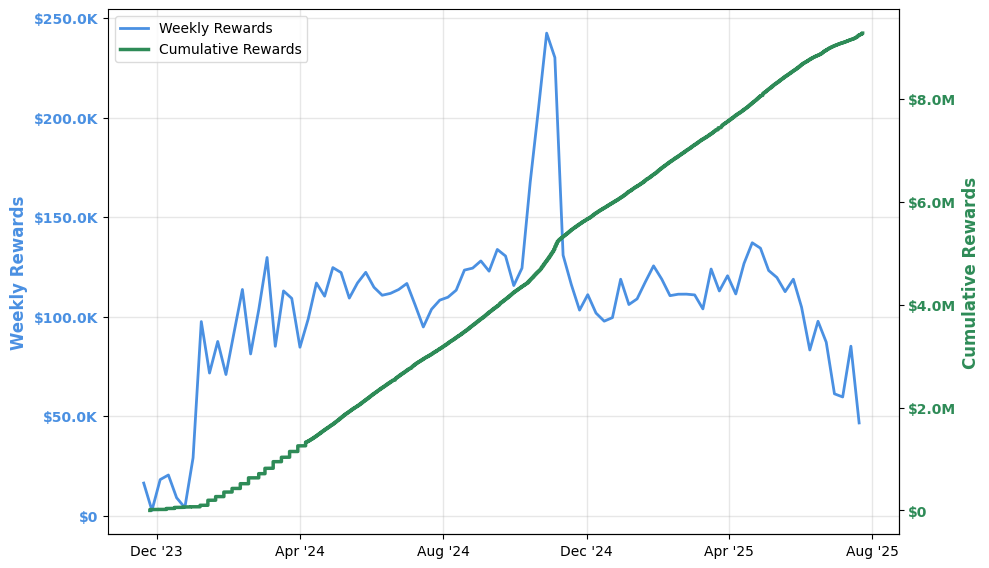

Start Date: 2023-11-25
End Date: 2025-07-24
Total Rewards: $9.3M
Highest Weekly Reward: $242.4K


In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# Create DataFrame and process timestamps
df = pd.DataFrame(db_results_rewards)
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.sort_values('datetime')

# Calculate cumulative sum of rewards over time
df['cumulative_rewards'] = df['value'].cumsum()

# Calculate weekly rewards
df['year_week'] = df['datetime'].dt.to_period('W')
weekly_rewards = df.groupby('year_week')['value'].sum().reset_index()
weekly_rewards['datetime'] = weekly_rewards['year_week'].dt.to_timestamp()

# Function to format y-axis labels
def format_currency(x, pos):
    if x >= 1e6:
        return f'${x/1e6:.1f}M'
    elif x >= 1e3:
        return f'${x/1e3:.1f}K'
    else:
        return f'${x:.0f}'

# Create the plot with dual y-axes
plt.style.use('default')
fig, ax1 = plt.subplots(figsize=(10, 6))

# Remove top and right spines
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)

# Left y-axis for weekly rewards (blue)
ax1.plot(weekly_rewards['datetime'], weekly_rewards['value'], linewidth=2, color='#4A90E2', label='Weekly Rewards')
# ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Weekly Rewards', fontsize=12, color='#4A90E2', fontweight='semibold')
ax1.tick_params(axis='y', labelcolor='#4A90E2')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_currency))


# Right y-axis for cumulative rewards (green)
ax2 = ax1.twinx()
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.plot(df['datetime'], df['cumulative_rewards'], linewidth=2.5, color='#2E8B57', label='Cumulative Rewards')
ax2.set_ylabel('Cumulative Rewards', fontsize=12, color='#2E8B57', fontweight='semibold')
ax2.tick_params(axis='y', labelcolor='#2E8B57')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_currency))

# Format x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))

# Set font weight for tick labels
for label in ax1.get_yticklabels():
    label.set_fontweight('semibold')
for label in ax2.get_yticklabels():
    label.set_fontweight('semibold')

for label in ax2.get_xticklabels():
    label.set_fontweight('semibold')
for label in ax2.get_xticklabels():
    label.set_fontweight('semibold')        

# Add title
# plt.title('Weekly and Cumulative Rewards Over Time', fontsize=16, pad=20, weight='bold')

# Remove grid and make it cleaner
ax1.grid(True, alpha=0.3, linewidth=1)

# Add combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, 
          fancybox=True, shadow=False, facecolor='white', edgecolor='lightgray')

# plt.figtext(0.5, 0.02, stats_text, ha='center', va='bottom', fontsize=10, 
#             fontweight='semibold', bbox=dict(boxstyle="round,pad=0.3", 
#             facecolor='lightgray', alpha=0.7))

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Make room for the text
plt.savefig('rewards_plot.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Calculate and print statistics
start_date = df['datetime'].min().strftime('%Y-%m-%d')
end_date = df['datetime'].max().strftime('%Y-%m-%d')
total_rewards = df['cumulative_rewards'].iloc[-1]
highest_weekly = weekly_rewards['value'].max()

print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"Total Rewards: {format_currency(total_rewards, 0)}")
print(f"Highest Weekly Reward: {format_currency(highest_weekly, 0)}")